# Preliminaries + Installs

These instructions are for Python 3.10
### Install Ollama
* `cd /tmp`
* `curl -fsSL https://ollama.com/install.sh | sh`
* Test, Optional (2GB download): `ollama run llama3.2`, Type `/bye` when done
### Install Langchain
* `python3.10 -m pip install langchain langchain_community langchain_chroma langchain_ollama llama-index-legacy pypdf langchain-unstructured "unstructured[pdf]" --user`
### Install SQLite ( >= 3.35.0 required, This will install 3.46 )
* `sudo apt install libreadline-dev python3.10-dev`
* `wget https://sqlite.org/2024/sqlite-autoconf-3460100.tar.gz`
* `tar -xvf sqlite-autoconf-3460100.tar.gz && cd sqlite-autoconf-3460100`
* `./configure`
* `make`
* `sudo make install`
* `python3.10 -m pip uninstall pysqlite3`
* `python3.10 -m pip install pysqlite3-binary --user`

# Build/Expand Document Database + Embeddings

## State

In [1]:
from os import environ, path
import time, sys, json
now = time.time

environ["_RAG_STATE_PATH"] = "data/state.json"

RAGstate = {
    'libDocs' : list(),
    'pages'   : dict(),
}

def save_state():
    global RAGstate
    with open( environ["_RAG_STATE_PATH"], 'w' ) as f:
        json.dump( RAGstate, f, indent = 4 )

def load_state():
    global RAGstate
    try:
        with open( environ["_RAG_STATE_PATH"], 'r' ) as f:
            RAGstate = json.load(f)
    except FileNotFoundError as e:
        print( f"Could not load {environ['_RAG_STATE_PATH']}!\n{e}" )

load_state()

Could not load data/state.json!
[Errno 2] No such file or directory: 'data/state.json'


## Helper Functions

In [2]:
from uuid import uuid4

def safe_str( data ):
    """Filters out invalid UTF-8 characters from a string."""
    return str( data ).encode( 'utf-8', 'ignore' ).decode( 'utf-8' )

def gen_ID():
    """ Generate a unique ID """
    return safe_str( uuid4() )

def pull_ollama_model( modelStr ):
    """ Pull a named model from Ollama and store it wherever """
    print( f"About to save '{modelStr}'.\nThis will spew a lot of text on the first run..." )
    os.system( f"ollama pull {modelStr}" )



## Copy PDFs

In [3]:
from os import path, makedirs
from aa_scrape_PDF import copy_pdfs

environ["_RAG_PDF_SOURCE"] = "/media/james/FILEPILE/$_Robust_Planning/Literature/References/storage"
environ["_RAG_PDF_DESTIN"] = "data/input/pdf"
environ["_RAG_PDF_ERROR"]  = "data/input/BAD_PDF"
environ["_RAG_PAGE_DESTN"] = "data/input/pages"
environ["_RAG_VERBOSE"]    =    ""
environ["_RAG_DOC_ADD"]    =   "200"
environ["_RAG_DOC_LIMIT"]  = "10000"
environ["_RAG_DOC_DBASE"]  = "lit_pdf"

if not path.exists( environ["_RAG_PDF_ERROR"] ):
    makedirs( environ["_RAG_PDF_ERROR"] )


## Determine if more docs will be loaded this session

In [4]:
__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop( 'pysqlite3' )
import chromadb
from langchain_chroma import Chroma


persistent_client = chromadb.PersistentClient()
collection        = persistent_client.get_or_create_collection( environ["_RAG_DOC_DBASE"] )

environ["_RAG_DOCDB_COUNT" ] = str( collection.count() )
environ["_RAG_DOCDB_REMAIN"] = str( min( int(environ["_RAG_DOC_LIMIT"])-len(RAGstate['libDocs']), int(environ["_RAG_DOC_ADD"]) ) )

print( f"{environ['_RAG_DOCDB_REMAIN']} files will be copied!" )

copy_pdfs()

200 files will be copied!
....

## Load PDFs by page chunks

### https://python.langchain.com/docs/how_to/document_loader_pdf/

* `python3.10 -m pip install pypdf langchain-unstructured "unstructured[pdf]" --user`
* `apt install tesseract-ocr`

In [5]:
import os, shutil
from collections import deque
from langchain_community.document_loaders import PyPDFLoader

if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    pdfs_drct = environ["_RAG_PDF_DESTIN"]
    eror_drct = environ["_RAG_PDF_ERROR" ]
    fNames    = [item for item in os.listdir( pdfs_drct ) if (str( item ).split('.')[-1].lower() == 'pdf')]
    print( f"There are {len(fNames)} files, {environ['_RAG_DOCDB_REMAIN']} to copy!" )
    pages  = deque() # Fast append
    lastLn = 0
    
    for i, fNam in enumerate( fNames ):
        file_path = str( path.join( pdfs_drct, fNam ) )
        if file_path not in RAGstate['libDocs']:
            try:
                loader    = PyPDFLoader( file_path )
                async for page in loader.alazy_load():
                    pages.append( page )
                print( f"{i+1}:{len(pages)}", end = ', ', flush = True )
                if len(pages) > lastLn:
                    RAGstate['libDocs'].append( file_path )
                lastLn = len(pages)
            except Exception as e:
                print( f"ERROR:{e}", end = ', ', flush = True )
                try:
                    shutil.move( file_path, path.join( eror_drct, fNam ) )
                except Exception as e:
                    print( f"FAILED to move {file_path} --to-> {path.join( eror_drct, fNam )}" )
            except asyncio.CancelledError as e:
                print( f"Load operation cancelled by user" )
                raise e
                    
            
    print()
    pages = list( pages )
    print( f"Read {len(pages)} pages in {(now()-bgn)/60.0} minutes!" )

save_state()

There are 200 files, 200 to copy!
1:12, 

Ignoring wrong pointing object 27 0 (offset 0)
Ignoring wrong pointing object 33 0 (offset 0)
Ignoring wrong pointing object 36 0 (offset 0)
Ignoring wrong pointing object 44 0 (offset 0)
Ignoring wrong pointing object 111 0 (offset 0)
Ignoring wrong pointing object 135 0 (offset 0)
Ignoring wrong pointing object 138 0 (offset 0)
Ignoring wrong pointing object 158 0 (offset 0)
Ignoring wrong pointing object 162 0 (offset 0)
Ignoring wrong pointing object 171 0 (offset 0)
Ignoring wrong pointing object 173 0 (offset 0)
Ignoring wrong pointing object 175 0 (offset 0)
Ignoring wrong pointing object 177 0 (offset 0)
Ignoring wrong pointing object 180 0 (offset 0)
Ignoring wrong pointing object 192 0 (offset 0)
Ignoring wrong pointing object 203 0 (offset 0)
Ignoring wrong pointing object 205 0 (offset 0)
Ignoring wrong pointing object 211 0 (offset 0)
Ignoring wrong pointing object 216 0 (offset 0)
Ignoring wrong pointing object 218 0 (offset 0)
Ignoring wrong pointing object 220 0 (offset

2:25, 3:40, 4:51, 5:57, 6:64, 7:85, 8:95, 9:122, 10:136, 11:157, 12:159, 13:176, 14:183, 15:194, 16:289, 17:296, 18:301, 19:313, 20:339, 21:349, 22:823, 23:836, 24:855, 25:860, 26:869, 27:883, 28:1923, 29:1943, 30:1948, 31:1951, 32:1971, 33:1990, 34:2058, 35:2074, 36:2085, 37:2097, 38:2107, 39:2116, 40:2152, 41:2167, 42:2190, 43:2209, 44:2230, 45:2238, 46:2255, 47:2299, 48:2307, 49:2325, 50:2339, 51:2357, 52:2366, 53:2374, 54:2407, 55:2424, 56:2432, 57:2450, 58:2464, 59:2507, 60:2527, 61:2549, 62:2581, 63:2614, 64:2623, 65:2669, 66:2686, 67:2696, 68:2704, 69:2710, 70:2736, 71:2750, 72:2764, 73:2781, 74:2789, 75:2816, 76:2825, 77:2848, 78:2861, 79:2890, 80:2913, 81:2924, 82:2932, 83:2942, 84:2988, 85:2995, 86:3007, 87:3028, 88:3038, 89:3045, 90:3058, 91:3076, 92:3084, 93:3096, 94:3121, 95:3133, 96:3141, 97:3144, 98:3157, 99:3188, 100:3198, 101:3228, 102:3240, 103:3258, 104:3259, 105:3291, 106:3309, 107:3320, 108:3343, 109:3360, 110:3369, 111:3392, 112:3423, 113:3433, 114:3463, 115:3471,

Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 25 0 (offset 0)
Ignoring wrong pointing object 122 0 (offset 0)
Ignoring wrong pointing object 127 0 (offset 0)
Ignoring wrong pointing object 132 0 (offset 0)
Ignoring wrong pointing object 134 0 (offset 0)
Ignoring wrong pointing object 143 0 (offset 0)
Ignoring wrong pointing object 148 0 (offset 0)
Ignoring wrong pointing object 153 0 (offset 0)
Ignoring wrong pointing object 155 0 (offset 0)
Ignoring wrong pointing object 223 0 (offset 0)
Ignoring wrong pointing object 225 0 (offset 0)
Ignoring wrong pointing object 227 0 (offset 0)
Ignoring wrong pointing object 229 0 (offset 0)
Ignoring wrong pointing object 231 0 (offset 0)
Ignoring wrong pointing object 233 0 (offset 0)
Ignoring wrong pointing object 235 0 (offset 0)
Ignoring wrong pointing object 237 0 (offset 0)
Ignoring wrong pointing object 239 0 (offset

161:4453, 162:4463, 163:4471, 164:4474, 165:4487, 166:4504, 167:4530, 168:4553, 169:4565, 170:4597, 171:4605, 172:4616, 

Advanced encoding [] not implemented yet


173:4651, 174:5020, 175:5038, 176:5073, 177:5082, 178:5098, 179:5117, 180:5125, 181:5140, 182:5174, 183:5197, 184:5209, 185:5232, 186:5255, 187:5278, 188:5317, 189:5338, 190:5345, 191:5362, 192:5383, 193:5395, 194:5406, 195:5415, 196:5431, 197:5440, 198:5467, 199:5480, 200:5537, 
Read 5537 pages in 3.622969853878021 minutes!


In [6]:
# print(f"{pages[0].metadata}\n")
# print(pages[0].page_content)

## Load the text embedding model

In [7]:
import sys, os, time
now = time.time

from langchain_ollama import OllamaEmbeddings

pull_ollama_model( "all-minilm" )

local_embeddings = OllamaEmbeddings( model = "all-minilm" )

About to save 'all-minilm'.
This will spew a lot of text on the first run...


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest 
pulling 797b70c4edf8... 100% ▕████████████████▏  45 MB                         
pulling c71d239df917... 100% ▕████████████████▏  11 KB                         
pulling 85011998c600... 100% ▕████████████████▏   16 B                         
pulling 548455b72658... 100% ▕████████████████▏  407 B                         
verifying sha256 digest 
writing manifest 
success 


## Populate document vector database (of pages)

In [8]:
import base64
import io

import fitz, pymupdf
from PIL import Image


def pdf_page_to_base64( pdf_path: str, page_number: int ):
    zoom_x       = 1.5  # horizontal zoom
    zoom_y       = 1.5  # vertical zoom
    mat          = pymupdf.Matrix( zoom_x, zoom_y )
    pdf_document = fitz.open( pdf_path )
    page         = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix          = page.get_pixmap( matrix = mat )
    img          = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    buffer       = io.BytesIO()
    
    img.save( buffer, format="PNG" )

    return base64.b64encode( buffer.getvalue() ).decode("utf-8")

In [9]:
import pickle

if not path.exists( environ["_RAG_PAGE_DESTN"] ):
    makedirs( environ["_RAG_PAGE_DESTN"] )


def get_page_meta_key( source, page ):
    """ Generate a (probably not) unique page key with useful data that can also be used for sorting """
    return str( source ).split('/')[-1].replace(' ','') + '_' + str( page )


if int(environ["_RAG_DOCDB_REMAIN"]) > 0:
    bgn = now()
    docIDs = [str( gen_ID() ) for _ in range( len(pages) )]
    dcmnts = [str( pg.page_content ) for pg in pages]
    metaDt = list()
    d      = 50

    for i, pg in enumerate( pages ):

        id_i  = docIDs[i]
        
        # Save Text Metadata #
        mDct = pg.metadata
        mDct['metakey'] = get_page_meta_key( pg.metadata['source'], pg.metadata['page'] )
        mDct['docID'  ] = id_i
        metaDt.append( mDct )

        # Save PDF Page image #
        try:
            pkl_i = path.join( environ["_RAG_PAGE_DESTN"], f"{id_i}.pkl" )
            pgPic = pdf_page_to_base64( pg.metadata['source'], pg.metadata['page'] )
            
            with open( pkl_i, 'wb' ) as f:
                RAGstate['pages'][ id_i ] = str( pkl_i )
                pickle.dump( pgPic, f )
        except Exception as e:
            print( f"Could NOT save image ID {id_i}!, {e}" )

        if (i % d == 0):
            print( '.', end='', flush = True )
    print()
    
    collection.add(
        ids       = docIDs, 
        metadatas = metaDt,
        documents = dcmnts
    )
    print( f"Added {len(dcmnts)} documents in {(now()-bgn)/60.0} minutes!" )

save_state()



...............................................................................................................


Exception occurred invoking consumer for subscription 45426e5e33cb4efbbbf119ef55664a44to topic persistent://default/default/bc1f3d54-0423-4175-a450-406fbc825e00 'utf-8' codec can't encode character '\ud835' in position 1322: surrogates not allowed


Added 5537 documents in 10.340526719888052 minutes!


# Create vector store

In [10]:
bgn = now()
vector_store_from_client = Chroma(
    client             = persistent_client,
    collection_name    = environ["_RAG_DOC_DBASE"],
    embedding_function = local_embeddings,
)
print( f"Built vector store in {(now()-bgn)} seconds!" )

Built vector store in 0.0024335384368896484 seconds!


# Load VLM

In [11]:
from langchain_ollama import ChatOllama

pull_ollama_model( "llava" )

llm = ChatOllama(
    model="llava",
)

About to save 'llava'.
This will spew a lot of text on the first run...


pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest 
pulling 170370233dd5... 100% ▕████████████████▏ 4.1 GB                         
pulling 72d6f08a42f6... 100% ▕████████████████▏ 624 MB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         
pulling c43332387573... 100% ▕████████████████▏   67 B                         
pulling ed11eda7790d... 100% ▕████████████████▏   30 B                         
pulling 7c658f9561e5... 100% ▕████████████████▏  564 B                         
verifying sha256 digest 
writing manifest 
success 


# Setup LangChain

In [12]:
os.environ["LANGCHAIN_TRACING_V1"] = "false"
os.environ["LANGCHAIN_TRACING_V2"] = "false"

# from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

# Retrieve and generate using the relevant snippets of the blog.
retriever = vector_store_from_client.as_retriever()

# Instantiation using from_template (recommended)
prompt1 = PromptTemplate( 
    template = """You are an expert assistant capable of interpreting textual information to provide accurate 
                  and detailed responses. You are provided with the following data:
                  Context: {docData}
                  Text query: {userQuery}
                  Use your understanding of the provided context to generate a response to based on 
                  relevant, up-to-date information. Ensure your answer is factually accurate, detailed, and leverages academic 
                  sources where possible. If additional context is required for clarification, request it from the user.""",
    input_variables = ["docData","userQuery"],
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain1 = (
    { "docData": retriever | format_docs, 
      "userQuery": RunnablePassthrough()}
    | prompt1
    | llm
    | StrOutputParser()
)

In [13]:
def ask_with_sources( q ):
    retrieved_docs = retriever.invoke( q )
    generated_ansr = rag_chain1.invoke( q )
    return {
        'response' : generated_ansr,
        'sources'  : retrieved_docs,
    }

In [14]:
def fetch_local_pages( sourceList ):
    global RAGstate
    rtnObjs = list()
    for source in sourceList:
        if source.metadata['docID'] in RAGstate['pages']:
            pklPath = RAGstate['pages'][ source.metadata['docID'] ]
            with open( pklPath, 'rb' ) as f:
                obj_i = pickle.load( f )
                rtnObjs.append( obj_i )
        else:
            print( f"No page with ID {source.metadata['docID']}" )
    return rtnObjs

In [15]:
from pprint import pprint
from IPython.display import Image as IPImage
from IPython.display import display
from langchain_core.messages import HumanMessage

def deep_doc_ask( q ):
    bgn = now()
    res = ask_with_sources( q ) 
    pprint( res['response'] )
    print( f"Initial LLM summary took {now()-bgn} seconds to process!" )
    
    pag = fetch_local_pages( res['sources'] )

    for p in pag:
        display( IPImage( data = base64.b64decode( p ) ) )
        message = HumanMessage(
            content=[
                {"type": "text", "text": q},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{p}"},
                },
            ],
        )
        bgn = now()
        response = llm.invoke( [message] )
        print( f"LLM query took {now()-bgn} seconds to process!" )
        pprint( response.content )

(' An efficient motion planning algorithm for robotic manipulation can be '
 'achieved through the use of probabilistic roadmap (PRM) methods. PRMs are '
 'graph-based planners that generate a roadmap by connecting a set of randomly '
 'generated nodes in configuration space with edges representing valid paths '
 'between them. One such method is Spark PRM, which focuses on expanding trees '
 'until some termination condition is reached, improving the connectivity of '
 'the roadmap.\n'
 'Another option for motion planning in robotic manipulation is the use of '
 'tree-based planners, such as RRTs and Expansive-Spaces Trees (ESTs). These '
 'methods gradually explore configuration space from a start configuration by '
 'iteratively selecting a random direction followed by finding the nearest '
 'node in the tree to the current configuration and stepping towards it. '
 'However, these methods may have difficulties exploring narrow spaces or '
 'obstacle boundaries.\n'
 'To address these

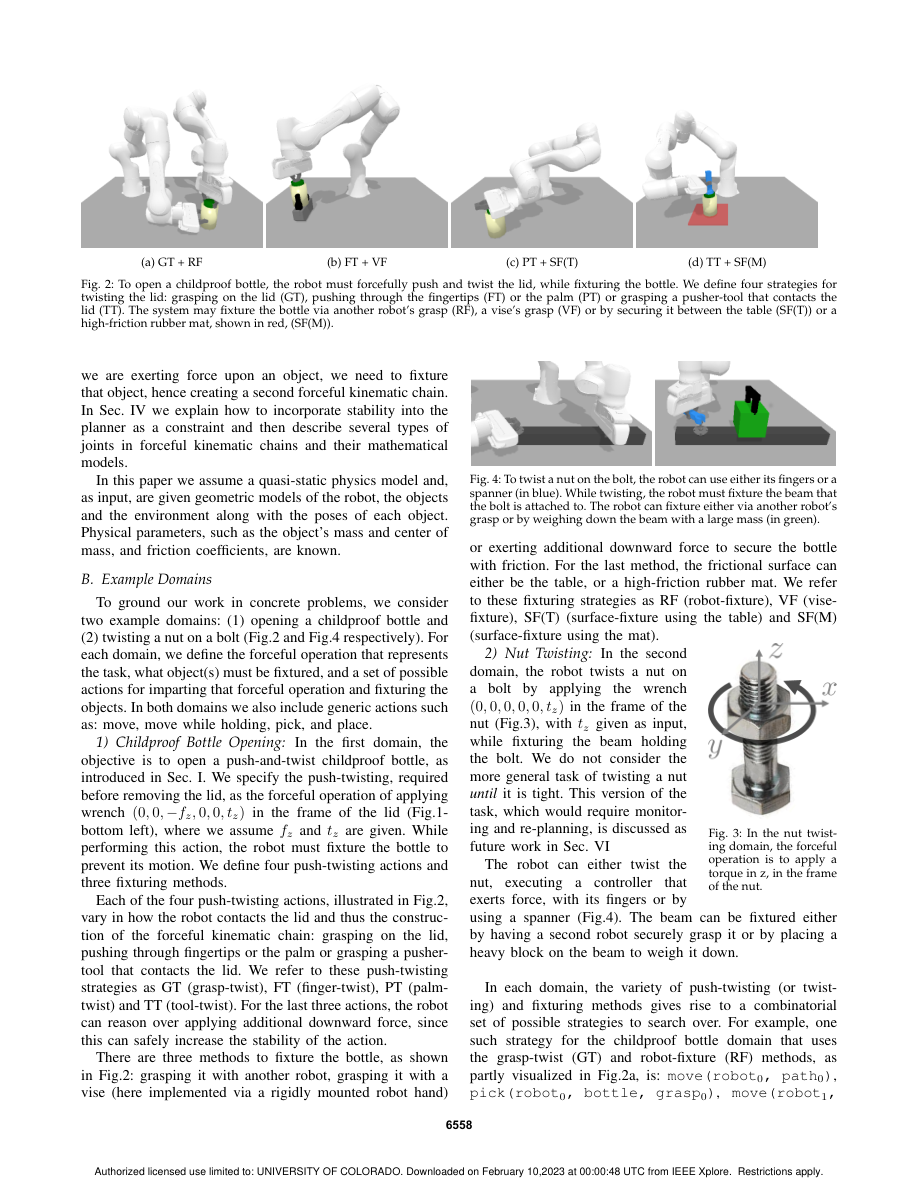

LLM query took 8.21744990348816 seconds to process!
(" The image you've provided appears to be a page from a document, but it's "
 'quite small and the text is not clear enough to read. If you need assistance '
 'with an efficient motion planning algorithm for robotic manipulation, please '
 'provide a higher resolution image or the text content so I can offer more '
 'specific information. ')


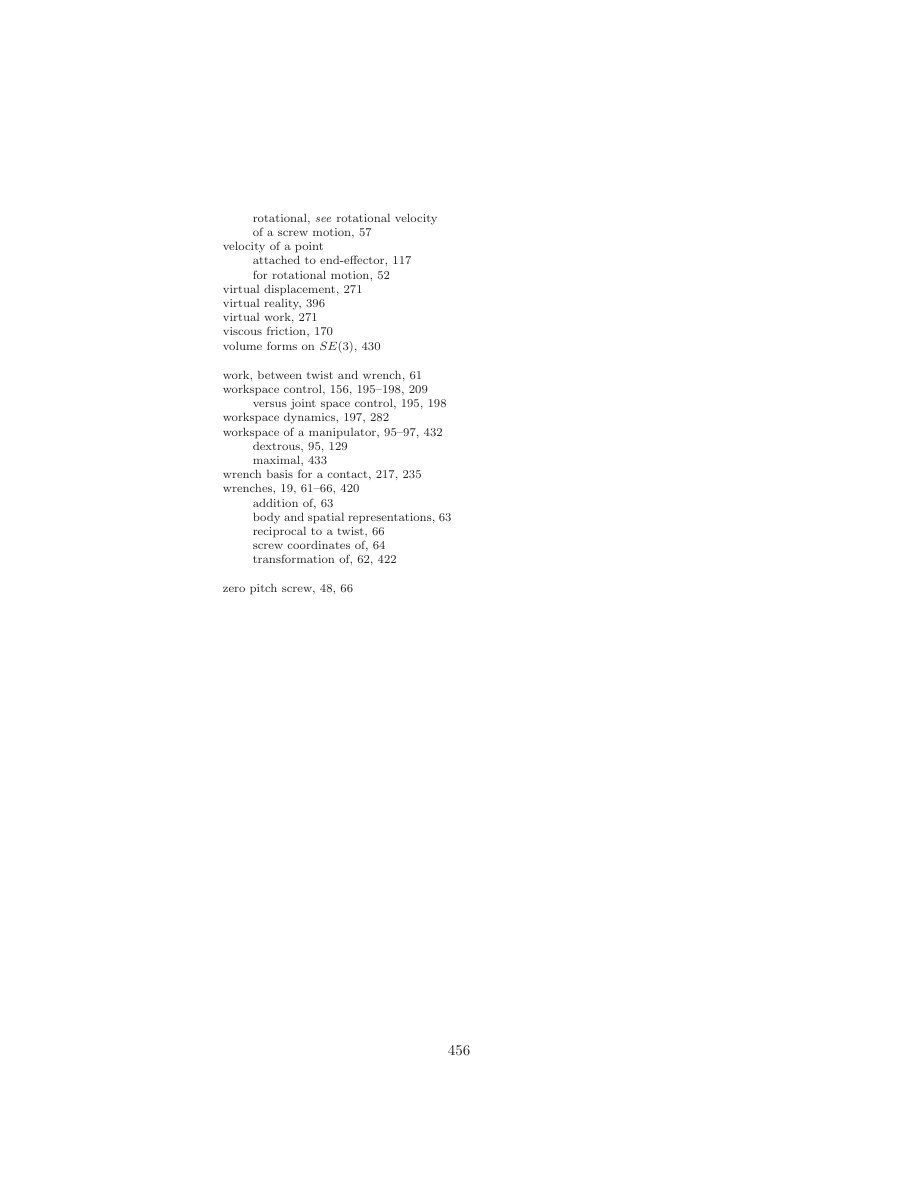

LLM query took 39.14230227470398 seconds to process!
(" The image you've provided shows a screenshot of a webpage or digital "
 'document with text that seems to be discussing some sort of motion planning '
 'algorithm. However, the quality and resolution of the image are not '
 'sufficient to read the specific details of the text, including the title or '
 'any algorithms described.\n'
 '\n'
 'To provide an efficient motion planning algorithm for robotic manipulation, '
 'several factors must be considered:\n'
 '\n'
 '1. **Objective Function**: The algorithm should have a clear objective '
 'function that defines what constitutes a successful trajectory for the robot '
 'arm. This could involve minimizing the distance traveled or the time taken '
 'to reach the goal position.\n'
 '\n'
 '2. **Constraints**: The algorithm should take into account any constraints '
 'on the motion, such as joint angle limits, workspace boundaries, or any '
 'other physical limitations of the robot arm.\n

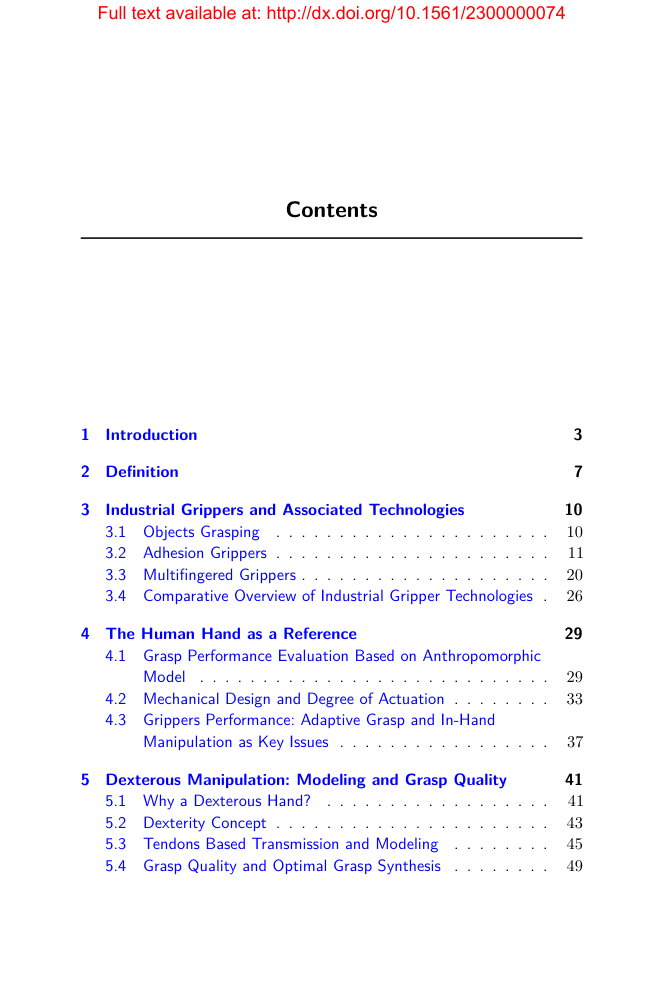

LLM query took 13.010687112808228 seconds to process!
(" The image you've provided appears to be a screenshot of a page from a "
 'presentation or document, likely related to robotics or engineering. On this '
 'page, there is a list with the title "Efficient motion planning algorithm '
 'for robotic manipulation." Below the title are several items, although only '
 'the first one is fully visible:\n'
 '\n'
 '- Introduction (defines industrial grippers and associated technologies)\n'
 '\n'
 'The list seems to be an outline or section of the presentation or document, '
 'possibly indicating different stages or components in the development or '
 'explanation of a motion planning algorithm for robotic manipulation. The '
 'text in the image suggests that the content is likely educational or '
 'informative, aimed at providing information about the subject matter at '
 'hand. ')


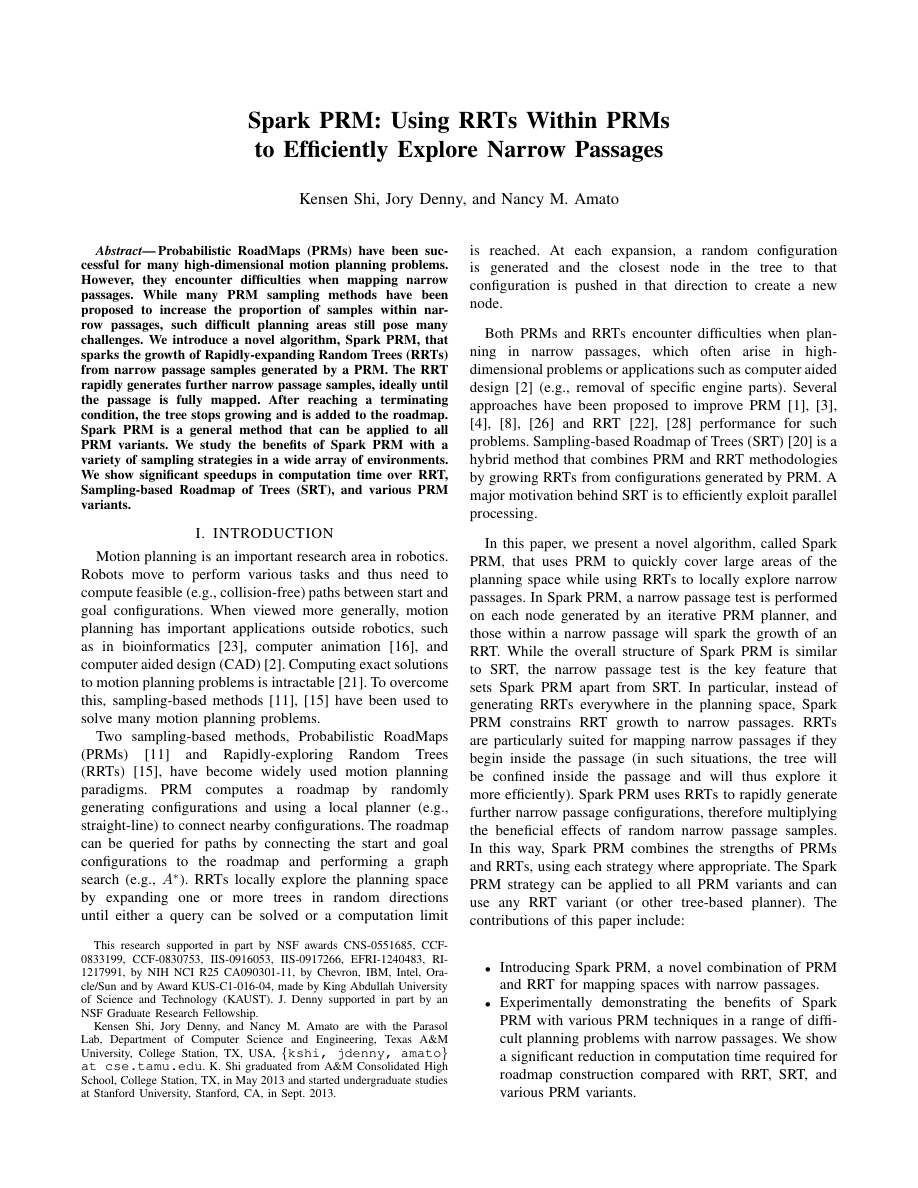

LLM query took 21.17268466949463 seconds to process!
(' The image shows a scientific paper titled "SparkM: Long-term Permanent '
 'Magnet (PMEM) within PnMs for Expert Motion Generation". This paper '
 'discusses an efficient motion planning algorithm for robotic manipulation.\n'
 '\n'
 'The abstract of the paper explains that SparkM is designed to perform '
 'long-term permanent magnet (PMEM) within PnMs, which are a class of neural '
 'networks. These networks are used in robotics for motion generation and '
 'control. By incorporating a long-term memory component within the PnM, '
 'SparkM can learn complex behaviors over time without requiring explicit '
 'transitions between behaviors.\n'
 '\n'
 'The authors present an experimental setup that includes a robotic arm with a '
 'gripper attached to it. This arm is capable of performing various tasks such '
 'as grasping objects and manipulating them in different environments. The '
 'paper also discusses the challenges faced in motio

In [16]:
deep_doc_ask( "Describe an efficient motion planning algorithm for robotic manipulation." )